# Reaching multiple targets with a manipulator
The objective of this exercise is to reach multiple targets with a manipulator.

We provide a basic example for reaching one point, and you have to modify it for sequence of multiple targets. Below it is the basic example, there we'll guide you to the final result.


## Set up

In [1]:
import magic_donotload

NB: as for all the tutorials, a magic command %do_not_load is introduced to hide the solutions to some questions. Change it for %load if you want to see (and execute) the solution.


We will need crocoddyl as in the previous notebook, with the model of the arm of the humanoid robot Talos, a 7-dof arm. It can be found in example robot data.

In [17]:
import crocoddyl
import pinocchio as pin
import numpy as np
import example_robot_data as robex

## The optimal-control program

First, let's load the Pinocchio model for the Talos arm.

In [5]:
# %load tp5/generated/arm_example_robexload
# First, let's load the Pinocchio model for the Talos arm.
robot = robex.load('talos_arm')


Set robot model.

In [7]:
# %load tp5/generated/arm_example_robot_model
# Set robot model
robot_model = robot.model
robot_model.armature = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.])*5
robot_model.q0 = np.array([3.5,2,2,0,0,0,0])
robot_model.x0 = np.concatenate([robot_model.q0, np.zeros(robot_model.nv)])
robot_model.gravity *= 0


Let's add a viewer to display the model.


In [9]:
# %load tp5/generated/arm_example_viz
# Configure viewer
from utils.meshcat_viewer_wrapper import MeshcatVisualizer
viz = MeshcatVisualizer(robot)
viz.display(robot_model.q0)
viz.addBox('world/box',[.1,.1,.1], [1.,0,0,1])
viz.addBox('world/goal',[.1,.1,.1],[0,1,0,1])
viz.applyConfiguration('world/goal',[0.2,0.5,.5,0,0,0,1])


Wrapper tries to connect to server <tcp://127.0.0.1:6000>
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [10]:
viz.viewer.jupyter_cell()

Configure the task.

In [12]:
# %load tp5/generated/arm_example_taskid
# Configure task
FRAME_TIP = robot_model.getFrameId("gripper_left_fingertip_3_link")
goal = np.array([.2,0.5,.5])


Create a cost model per the running and terminal action model.

In [14]:
# %load tp5/generated/arm_example_stateandcosts
# Create a cost model per the running and terminal action model.
state = crocoddyl.StateMultibody(robot_model)
runningCostModel = crocoddyl.CostModelSum(state)
terminalCostModel = crocoddyl.CostModelSum(state)


Note that we need to include a cost model (i.e. set of cost functions) in order to fully define the action model for our optimal control problem.
For this particular example, we formulate three running-cost functions: goal-tracking cost, state and control regularization; and a terminal cost: goal cost. First, let's create the common cost functions.

In [18]:
# %load tp5/generated/arm_example_costs
# Cost for 3d tracking || p(q) - pref ||**2
goalTrackingRes = crocoddyl.ResidualModelFrameTranslation(state,FRAME_TIP,goal)
goalTrackingCost = crocoddyl.CostModelResidual(state,goalTrackingRes)

# Cost for 6d tracking  || log( M(q)^-1 Mref ) ||**2
Mref = pin.SE3(pin.utils.rpyToMatrix(0,np.pi/2,-np.pi/2), goal)
goal6TrackingRes = crocoddyl.ResidualModelFramePlacement(state,FRAME_TIP,Mref)
goal6TrackingCost = crocoddyl.CostModelResidual(state,goal6TrackingRes)

# Cost for state regularization || x - x* ||**2
xRegWeights = crocoddyl.ActivationModelWeightedQuad(np.array([1,1,1,1,1,1,1, 1,1,1,1,2,2,2.]))
xRegRes = crocoddyl.ResidualModelState(state,robot_model.x0)
xRegCost = crocoddyl.CostModelResidual(state,xRegWeights,xRegRes)

# Cost for control regularization || u - g(q) ||**2
uRegRes = crocoddyl.ResidualModelControlGrav(state)
uRegCost = crocoddyl.CostModelResidual(state,uRegRes)

# Terminal cost for state regularization || x - x* ||**2
xRegWeightsT=crocoddyl.ActivationModelWeightedQuad(np.array([1,1,1,1,1,1,1, 1,1,1,1,2,2,2.]))
xRegResT = crocoddyl.ResidualModelState(state,robot_model.x0)
xRegCostT = crocoddyl.CostModelResidual(state,xRegWeightsT,xRegResT)


Then let's added the running and terminal cost functions

In [20]:
# %load tp5/generated/arm_example_addcosts
# Then let's added the running and terminal cost functions
runningCostModel.addCost("gripperPose", goalTrackingCost, .001)
runningCostModel.addCost("xReg", xRegCost, 1e-3)
runningCostModel.addCost("uReg", uRegCost, 1e-6)
terminalCostModel.addCost("gripperPose", goal6TrackingCost, 10)
terminalCostModel.addCost("xReg", xRegCostT, .01)


Next, we need to create an action model for running and terminal knots. The
forward dynamics (computed using ABA) are implemented inside DifferentialActionModelFullyActuated.

In [22]:
# %load tp5/generated/arm_example_iam
actuationModel = crocoddyl.ActuationModelFull(state)
dt = 1e-2
runningModel = crocoddyl.IntegratedActionModelEuler(
    crocoddyl.DifferentialActionModelFreeFwdDynamics(state, actuationModel, runningCostModel), dt)
runningModel.differential.armature = robot_model.armature
terminalModel = crocoddyl.IntegratedActionModelEuler(
    crocoddyl.DifferentialActionModelFreeFwdDynamics(state, actuationModel, terminalCostModel), 0.)
terminalModel.differential.armature = robot_model.armature


For this optimal control problem, we define 250 knots (or running action
models) plus a terminal knot

In [24]:
# %load tp5/generated/arm_example_shoot
T = 100
problem = crocoddyl.ShootingProblem(robot_model.x0, [runningModel] * T, terminalModel)


We finalize the set up by creating the DDP solver for this optimal control problem.

In [25]:
ddp = crocoddyl.SolverDDP(problem)

Callbacks can be added, for example to at verbose output when the solver runs, or logs the data of the descent algorithm.

In [27]:
# %load tp5/generated/arm_example_callbacks
ddp.setCallbacks([
    crocoddyl.CallbackLogger(),
    crocoddyl.CallbackVerbose(),
])


The DDP algorithm is run by the solver with:

In [28]:
ddp.solve([],[],1000)  # xs_init,us_init,maxiter

iter     cost         stop         grad         xreg         ureg       step    ||ffeas||
   0  7.24384e+00  3.96284e-06  6.24350e+01  1.00000e-09  1.00000e-09  1.0000  3.50000e+00
   1  4.78676e+00  1.07423e-02  1.39592e+01  1.00000e-09  1.00000e-09  0.5000  0.00000e+00
   2  2.70989e+00  1.25529e-04  9.29161e+00  1.00000e-09  1.00000e-09  0.5000  0.00000e+00
   3  9.67695e-01  1.13765e-04  5.23078e+00  1.00000e-09  1.00000e-09  1.0000  0.00000e+00
   4  3.46783e-01  1.00643e-04  1.78543e+00  1.00000e-09  1.00000e-09  1.0000  0.00000e+00
   5  8.53420e-02  4.39166e-08  5.30328e-01  1.00000e-09  1.00000e-09  1.0000  0.00000e+00
   6  8.18272e-02  3.55603e-07  8.95525e-03  1.00000e-09  1.00000e-09  1.0000  0.00000e+00
   7  8.13610e-02  9.08721e-08  1.79388e-03  1.00000e-09  1.00000e-09  1.0000  0.00000e+00
   8  8.11703e-02  6.82986e-08  7.41040e-04  1.00000e-09  1.00000e-09  1.0000  0.00000e+00
   9  8.10962e-02  2.14822e-08  3.14928e-04  1.00000e-09  1.00000e-09  1.0000  0.00000e+00


True

  12  8.10541e-02  6.60512e-10  3.19400e-05  1.00000e-09  1.00000e-09  1.0000  0.00000e+00


You can now look at the results, either in Gepetto-viewer by running the trajectory, or by plotting it.

In [29]:
# %load -r 103-104 tp5/arm_example.py
import tp5.croco_utils as crocutils
crocutils.displayTrajectory(viz,ddp.xs,ddp.problem.runningModels[0].dt,12)

And plotting...

In [30]:
%matplotlib inline

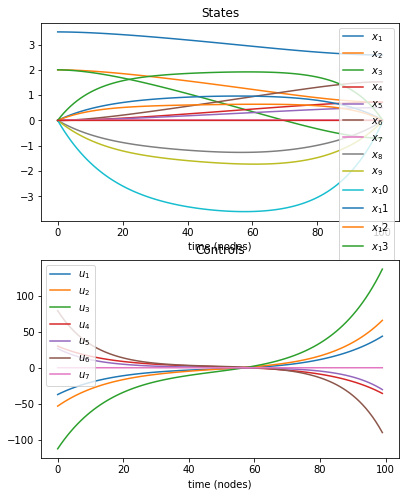

In [33]:
# %load -r 97-99 tp5/arm_example.py
log = ddp.getCallbacks()[0]
crocutils.plotOCSolutions(log.xs, log.us)

Some elements describing the solver convergence can also been plotted.

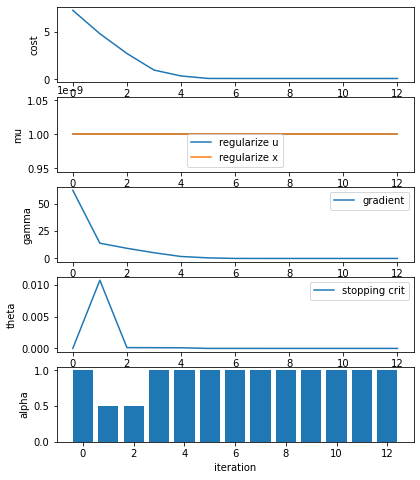

In [34]:
crocutils.plotConvergence(log)

## I. DifferentialActionModel for Pinocchio ABA
This scenario uses an action model that computes 2nd order differential dynamics with Pinocchio. Note that it can accept several cost models. This action model is tailored for robot applications, and at the same time, it's modular since:
 - you can modify the robot dynamics by changing Pinocchio model, and
 - you can formulate any cost function by simply adding running a terminal costs.

## II. Cost models

A cost model computes a scalar cost value and its gradient and Hessian. All the models implemented are computing a cost residual and are computing the Hessian with the Gauss approximation.

We implemented reusable cost models for controlling 
 - a frame placement (translation or velocity),
 - the center of mass position, and 
 - state  and control spaces.

In the example above, we used the CostModelFrameTranslation which defines a 3d position task, and the state and control regularizers.

All functions are defined by their *model*, which is const, i.e none of its fields is modified by the *calc* and *calcDiff* calls. Temporary buffers are defined in a companion *data*.

In [35]:
dataCollector = crocoddyl.DataCollectorMultibody(robot.data)
trackData = goalTrackingCost.createData(dataCollector)

### II.a Frame position cost

You define a frame ID and the reference position as a 3D array. The cost is the distance between the frame and the target. This cost depends on $\mathbf{x}$ (specifically the configuration $\mathbf{q}$). You can double check the 0s in its gradient.

In [34]:
x = ddp.xs[1].copy()
q = x[:state.nq]
pinocchio.updateFramePlacements(robot.model, robot.data)
pinocchio.computeJointJacobians(robot.model, robot.data, q)
goalTrackingCost.calc(trackData, x)
goalTrackingCost.calcDiff(trackData, x)
print('Lx = ',trackData.Lx)
print('Lu = ',trackData.Lu)

Lx =  [-0.07596597  0.03892435  0.13087767 -0.01389783 -0.01787752  0.05840131
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
Lu =  [0. 0. 0. 0. 0. 0. 0.]


### II.b State cost
In this part of the tutorial you must define a State model. It defines 
 - the dimension of the state and its tangent, and
 - the exponential/integrate and difference/log operators.
The operators can described using Pinocchio functions. And the exercite consists on adding them into your State class. Please note crocoddyl has abstract functions for this.

The state cost uses a reference in state space (State.zero() by default). The cost is the distance, computed with state.difference between the current state and the reference. Hence, with this cost, we regularize both position and velocity.

### II.c Control cost

The control cost uses a control reference as in the state cost. The cost is the distance the current control and the reference. Hence the cost regularizes torque commands.

### II.d Add cost models to the differential action model
Each time we want to include a new cost function, we use addCost function inside our DAM. In this function you're also able its weight.

## III. Create the problem with integrated action model
Differential action models describe cost and dynamics in continuous-time, however our optimal control solvers work in discrete-time. We have created the integrated action model in order to deal with this.

In the previous code, we have used an abstract class that uses simpletic Euler rules. In the cartpole exercise you have learnt how to use integrated action models for your problem.

## IV. Callbacks

Callback functions are needed for analysing and debugging the performance of the solver for your specific problem.
For problems defined with Pinocchio, you can display the robot trajectory per each iterate by including CallbackDisplay. With this callback, you can display robot motions with different rates. Additionally, CallbackVerbose prints a message that allows us to understand the behaviour of the solver.

Generally speaking, an user is able to describe any callback function. This function will be run once per iterate and it has access to all data.

## VI. Modifying the example

Start by defining several targets (let's say 4 targets, all at x=0.4, and at y and z being either 0 or 0.4), and display then in the viewer.


The shooting problem will be composed of 4 sequences of action models. Each sequence consists on T shooting "running" nodes and 1 terminal node. The running nodes mostly have regularization terms, while the terminal nodes have a strong cost toward the respective target.

[ R1,R1,R1 ... R1,T1, R2,R2 .... R2, T2, R3 ... R3, T3, R4 ... R4 ] , T4

First create 4 running models and 4 terminal models.

Then you need to add a position cost, and state and control regularization to each running action model. Please  note that for terminal action model is only needed the position cost. Additionally, in the running models, the position cost should be low, and it should be high in the terminal models.

Now create a shooting problem.

In [ ]:
seq0 = [runningModels[0]]*T + [terminalModels[0]]
seq1 = [runningModels[1]]*T + [terminalModels[1]]
seq2 = [runningModels[2]]*T + [terminalModels[2]]
seq3 = [runningModels[3]]*T 
problem = crocoddyl.ShootingProblem(x0,seq0+seq1+seq2+seq3,terminalmodel[3])

Create a DDP solver for this problem and run it. 

In [ ]:
ddp = crocoddyl.SolverDDP(problem)
ddp.solve()

Well, it should not work, at least no on the first shot. The DDP solver is likely not strong enough to accept the random weights that you have selected. 

If it is working nicely from the first shot, display it in the viewer and go take a coffee. But you will likely have to tweak the gains to make it work.

**It is suggested to first optimize only sequence 1. When you are happy with it, add sequence 2 and optimize again, etc.**


## V. Penalty
The solver works with double precisions, so it is quite robust to high weight. 10000 is likely to be accepted for example. But if you make the problem too difficult, the solver will break. 

In that case, you can implement a simple penalty solver by setting the weight to be 10**i, and creating a for loop to explore i from 0 to 5. At each iteration of the loop, run the solver from the previous solution and for few iterations only.

In [ ]:
for i in range(1,6):
    for m in terminalModels:
        m.costs.costs['gripperPose'].weight = 10**i
    ddp.solve(ddp.xs, ddp.us, 10)